In [1]:
!mkdir ../data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O ../data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd ../data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

mkdir: ../data: File exists
--2021-03-24 19:30:32--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-03-24 19:30:32--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘../data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

../data/pbmc3k_filt 100%[===================>]   7.27M  8.40MB/s    in 0.9s    

2021-03-24 19:30:33 (8.40 MB/s) - ‘../data/pbmc3k_filtered_gene_

In [2]:
! ls ../data

filtered_gene_bc_matrices
pbmc3k_expression_log2TP10K_20210324.tsv
pbmc3k_filtered_gene_bc_matrices.tar.gz
pbmc3k_umap_20210324.tsv


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
adata = sc.read_10x_mtx(
    '../data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False)                              # write a cache file for faster subsequent reading

In [3]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

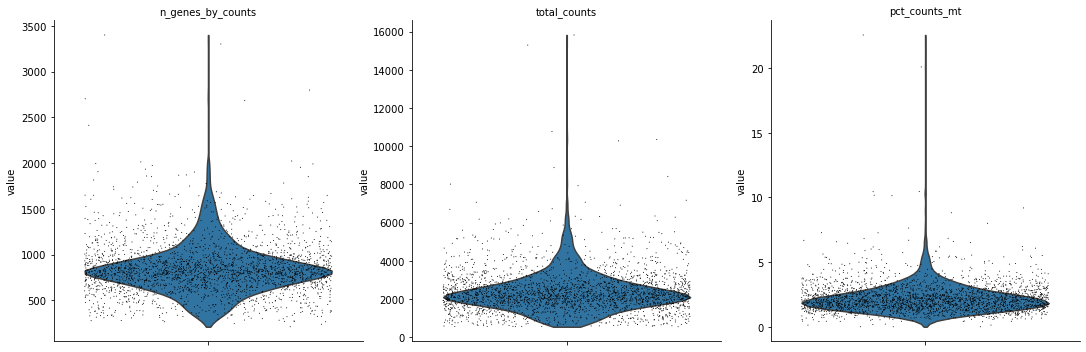

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

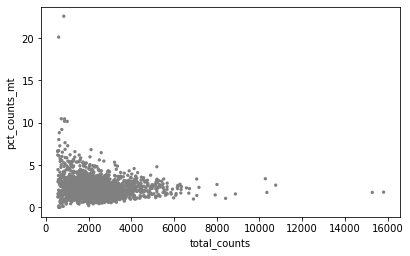

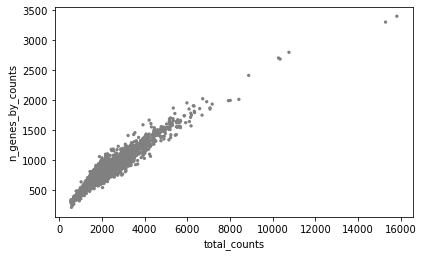

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [9]:
toremove = [x for x in adata.var.index if ('MT-' in x) or ('.' in x) or ('-' in x) or (x[0:3] == 'RPS') or (x[0:3] == 'RPL')] + ['MALAT1']

In [10]:
adata = adata[:, ~adata.var.index.isin(toremove)]

In [11]:
sc.pp.filter_cells(adata, min_genes=200)

Trying to set attribute `.obs` of view, copying.


In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [13]:
sc.pp.log1p(adata)


In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


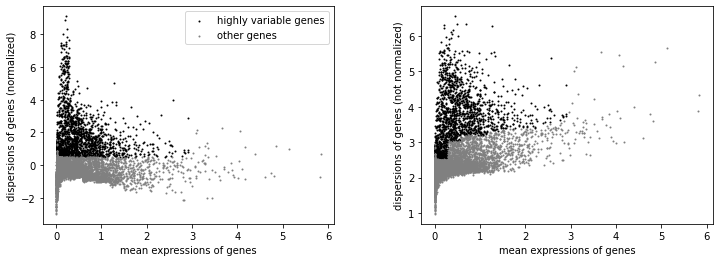

In [15]:
sc.pl.highly_variable_genes(adata)


In [16]:
adata.raw = adata

In [17]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

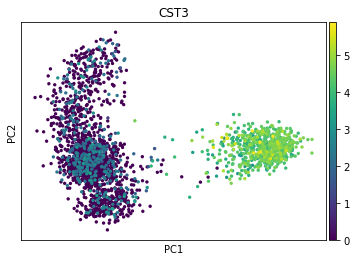

In [18]:
sc.pl.pca(adata, color='CST3')

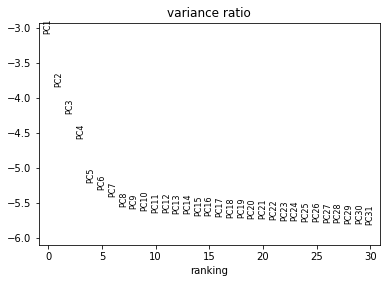

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
adata

AnnData object with n_obs × n_vars = 2634 × 12037
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [21]:
2638*.005

13.19

In [22]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=8)

In [23]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0)

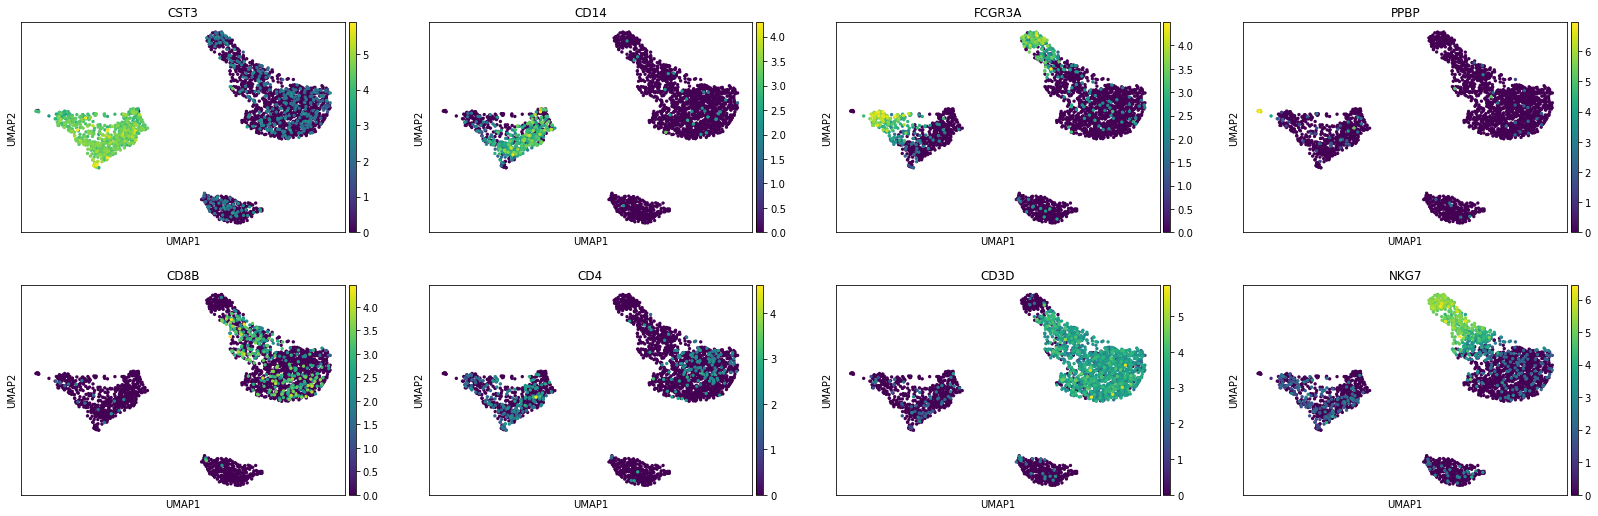

In [24]:
sc.pl.umap(adata, color=['CST3','CD14', 'FCGR3A', 'PPBP', 'CD8B', 'CD4', 'CD3D', 'NKG7'])

In [25]:
X = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)

In [26]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['UMAP_1', 'UMAP_2'])
umap.head()

,UMAP_1,UMAP_2
AAACATACAACCAC-1,11.257295,12.561447
AAACATTGAGCTAC-1,7.166475,-2.057729
AAACATTGATCAGC-1,15.217629,12.554446
AAACCGTGCTTCCG-1,-1.826561,6.781221
AAACCGTGTATGCG-1,7.656905,17.598440


In [27]:
X.to_csv('../data/pbmc3k_expression_log2TP10K_20210324.tsv.gz', sep='\t')

In [28]:
umap.to_csv('../data/pbmc3k_umap_20210324.tsv', sep='\t')

In [29]:
! gsutil -m cp ../data/* gs://sabeti-public/dkotliar/scnavigator/pbmc3k/data/

Omitting directory "file://../data/filtered_gene_bc_matrices". (Did you mean to do cp -r?)
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying file://../data/pbmc3k_expression_log2TP10K_20210324.tsv [Content-Type=text/tab-separated-values]...
Copying file://../data/pbmc3k_expression_log2TP10K_20210324.tsv.gz [Content-Type=text/tab-separated-values]...
Copying file://../data/pbmc3k_umap_20210324.tsv [Content-Type=text/tab-separated-values]...
Copying file://../data/pbmc3k_filtered_gene_bc_matrices.tar.gz [Content-Type=application/x-tar]...
/ [4/4 files][145.2 MiB/145.2 MiB] 100% Done   1.9 MiB/s ETA 00:00:00           
Operation completed over 4 objects/145.2 MiB.                      

In [30]:
rm -R ../data